

# Loan Default Probability 

The goal of this project is to build a machine learning model to predict the probability that a loan will default.

[Lending Club’s loan data](https://www.kaggle.com/datasets/mlfinancebook/lending-club-loans-data) from 2007-2017 adopted from Kaggle

## 1. Load dataset

**Import the libraries**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pickle import dump
from pickle import load

# #Libraries for Deep Learning Models
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.optimizers import SGD

**Read in the data** 


In [79]:
# Read the large CSV file
#df = pd.read_csv('data/loan_data.csv')

# Save the DataFrame to a pickle file
#df.to_pickle('data/loan_data_pickle.pkl')

df = pd.read_pickle('data/loan_data_pickle.pkl')

In [4]:
# make sure nothing's being truncated

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0.0,Aug-1994,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,0.00,0.00,17392.37,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-2016,12017.81,NaN,Nov-2017,684.0,680.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,149140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500.0,NaN,NaN,NaN,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0.0,Sep-1989,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,0.00,0.00,6611.69,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-2016,321.08,NaN,Feb-2017,564.0,560.0,0.0,59.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,162110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [6]:
print('dataset dimension: ',df.shape)
print('dataset columns: ',df.columns)

dataset dimension:  (1646801, 150)
dataset columns:  Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'm

## 2. Data Preparation pt.1

**Prepare target variable**

In [7]:
# We're going to try to predict the loan_status. Let's take a closer look at this variable.
df['loan_status'].value_counts(dropna=False)

loan_status
Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: count, dtype: int64

We're only going to look at completed loans that are either "Fully Paid" or "Charged Off"/"Default". This means, we'll only keep the rows where loan_status is one of "Fully Paid", "Charged Off", or "Default".

A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. The predicted variable takes value 1 in case of charge-off and 0 otherwise.

In [80]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

# Prepare our target variable by adding a 'defaulted' column
df['defaulted'] = (df['loan_status'].isin(['Charged Off', 'Default'])).apply(np.uint8)
df.drop('loan_status', axis=1, inplace=True)

print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 150)


## 3. EDA pt.1

**3.1 Missing Values in features**

In [81]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
frac_data_has_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]

print('fraction of missing values features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('\n\n data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

print('\n\n fraction of data with missing values:',frac_data_has_missing) # returning 1 -- meaning that all datapoints contain some missing values in features

fraction of missing values features:
member_id                                     1.000000
emp_title                                     0.059596
emp_length                                    0.051843
desc                                          0.853101
title                                         0.009718
dti                                           0.000044
inq_last_6mths                                0.000001
mths_since_last_delinq                        0.511870
mths_since_last_record                        0.835398
revol_util                                    0.000601
last_pymnt_d                                  0.001802
next_pymnt_d                                  0.999914
last_credit_pull_d                            0.000048
collections_12_mths_ex_med                    0.000069
mths_since_last_major_derog                   0.747954
annual_inc_joint                              0.995360
dti_joint                                     0.995360
verification_status_joint   

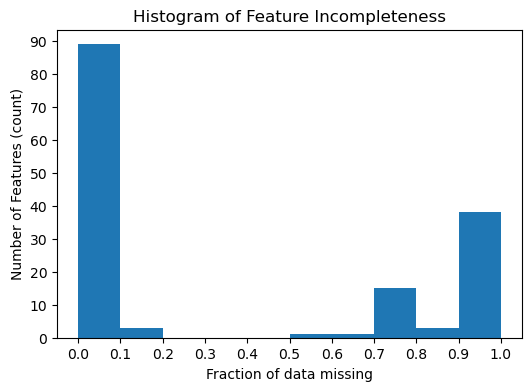

In [82]:
perc_missing_per_ftr = perc_missing_per_ftr.sort_values(ascending=False)

plt.figure(figsize=(6,4))
perc_missing_per_ftr.plot.hist(bins=10)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Number of Features (count)')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 100, 10));

In [83]:
small_frac_missing_ftr = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr < 0.2].index))
mid_frac_missing_ftr = sorted(list(perc_missing_per_ftr[(perc_missing_per_ftr >= 0.2) & (perc_missing_per_ftr <= 0.5)].index))
large_frac_missing_ftr = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr > 0.5].index))
print("< 20% missing data Features: ", len(small_frac_missing_ftr),' i.e.', np.around(len(small_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')
print("20% - 50% missing data Features: ", len(mid_frac_missing_ftr),' i.e.', np.around(len(mid_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')
print("> 50% missing data Features: ", len(large_frac_missing_ftr),' i.e.', np.around(len(large_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')

< 20% missing data Features:  92  i.e. 61.33 % of total features
20% - 50% missing data Features:  0  i.e. 0.0 % of total features
> 50% missing data Features:  58  i.e. 38.67 % of total features


Here we see that about 60% features have <20% missing data, and the rest 40% have >50% missing data. Since we have a relatively large dataset, we'll still be able to keep the diversity of our dataset as well as many useful information needed in our classification task. Hence, in our later data preparation steps, we can eliminate those features with a large fraction of missing values.  

**3.2 Target Variable ("defaulted")**

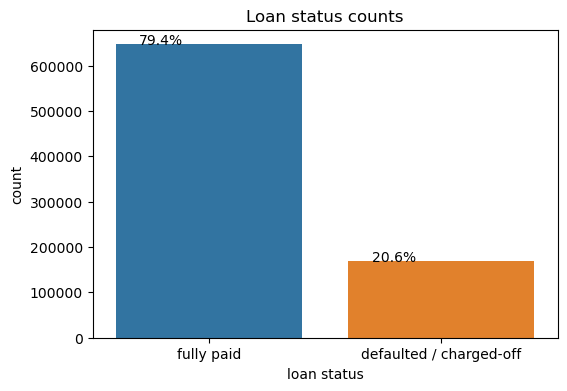

In [84]:
plt.figure(figsize=(6,4))

ax=sns.countplot(x='defaulted', data=df)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df['defaulted'])), (p.get_x()+0.1, p.get_height()+5))

plt.title("Loan status counts")
plt.xlabel("loan status")
plt.xticks([0,1],["fully paid", "defaulted / charged-off"])
plt.show()

We see that about 80% of the loans are fully paid and about 20% have charged off / defaulted, giving us an unbalanced classification problem.


## 4. Data Preparation pt.2

**Select Features**

Since we have 150 features here, in order to save computing power, we'll only keep the most relevant features to feed into our ML model. Features will be selected based on the following criteria:
- Eliminate features with > 20% missing values.
- Eliminate features that are not available to investors when making investment decisions.
- Eliminate features with low correlation with the target variable "defaulted".

**4.1 eliminate features with >20% missing values**

In [85]:
drop_list = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr > 0.2].index))
print(drop_list)
print('dropped number of features: ',len(drop_list))

df.drop(labels=drop_list, axis=1, inplace=True)
print('dataset dimension: ',df.shape)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

**4.2 eliminate features that are not available to investors when making investment decisions**

There's no better way to do this rather than going through the feature description and manually deciding which features would have been available to potential investors before an investment decision was made. 

In [87]:
# current feature list
print('# features: ',len(df.columns))
print('features sorted in alphabetical order: ',sorted(df.columns))

# features decided to keep:
keep_list = ['acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'defaulted', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'open_acc', 'out_prncp', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'total_pymnt', 'total_rec_int', 'verification_status', 'zip_code']
print('# features kept: ',len(keep_list))

# drop the other features
drop_list = [col for col in df.columns if col not in keep_list]
df.drop(labels=drop_list, axis=1, inplace=True)
print('dataset dimension: ',df.shape)

# features:  92
features sorted in alphabetical order:  ['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'defaulted', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_re

**4.3 eliminate features with low correlation with the target variable "defaulted"**

In [102]:
# calculate the correlation
df['defaulted'] = df['defaulted'].astype('float64')
float_features = df.select_dtypes(include=['float64'])
correlation = float_features.corr()
correlation_defaulted = abs(correlation['defaulted']).sort_values(ascending=False)
print(correlation_defaulted)

defaulted                1.000000
last_pymnt_amnt          0.381411
total_pymnt              0.350998
int_rate                 0.247824
fico_range_low           0.139471
fico_range_high          0.139470
dti                      0.123057
acc_open_past_24mths     0.099007
bc_open_to_buy           0.086927
avg_cur_bal              0.085786
num_actv_rev_tl          0.077226
bc_util                  0.077168
mort_acc                 0.077101
revol_util               0.072213
funded_amnt              0.064280
loan_amnt                0.064161
total_rec_int            0.053620
mo_sin_rcnt_rev_tl_op    0.053411
mo_sin_old_rev_tl_op     0.048513
annual_inc               0.046680
installment              0.046310
open_acc                 0.034675
pub_rec                  0.023115
pub_rec_bankruptcies     0.017334
out_prncp                0.014772
revol_bal                0.013156
total_acc                0.011180
Name: defaulted, dtype: float64


In [104]:
# we decide to drop the last few features with a correlation value <0.015
drop_list_corr = sorted(list(correlation_defaulted[correlation_defaulted < 0.015].index))
print(drop_list_corr)

df.drop(labels=drop_list_corr, axis=1, inplace=True)
print('dataset dimension: ',df.shape)

['out_prncp', 'revol_bal', 'total_acc']
dataset dimension:  (815056, 39)


## 5. EDA pt.2

**5.1 General patterns**